<a href="https://colab.research.google.com/github/blackdragonae/mcmc/blob/main/mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MCMC code**

In [22]:
!pip install zeus-mcmc
!pip install getdist

Importando librerias

In [23]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from astropy.table import Table
from astropy.cosmology import FlatwCDM
from getdist import plots, MCSamples
import zeus
from zeus import ChainManager
import numpy as np
import scipy.optimize as op
from multiprocessing import Pool

**Montecarlo Method to calcualte Pi**

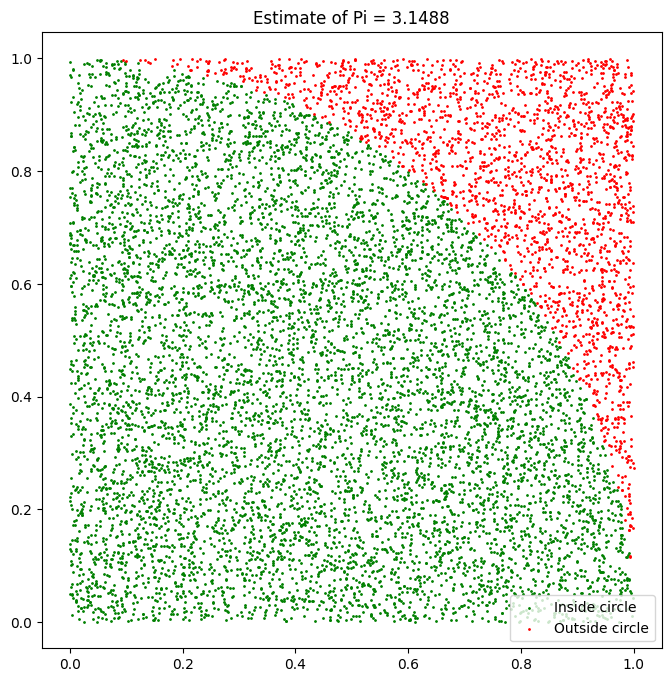

In [25]:
def estimate_pi(num_samples):
    inside_circle = 0
    inside_x = []
    inside_y = []
    outside_x = []
    outside_y = []

    for _ in range(num_samples):
        x, y = random.random(), random.random()
        if x**2 + y**2 <= 1:
            inside_circle += 1
            inside_x.append(x)
            inside_y.append(y)
        else:
            outside_x.append(x)
            outside_y.append(y)

    pi_estimate = 4 * inside_circle / num_samples
    return pi_estimate, inside_x, inside_y, outside_x, outside_y

# Number of samples
num_samples = 10000
pi_estimate, inside_x, inside_y, outside_x, outside_y = estimate_pi(num_samples)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(inside_x, inside_y, color='green', s=1, label='Inside circle')
plt.scatter(outside_x, outside_y, color='red', s=1, label='Outside circle')
plt.legend()
plt.axis('equal')
plt.title(f'Estimate of Pi = {pi_estimate}')
plt.show()

**Estimación de parametros cosmológico con Zeus**

In [26]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Función Log Likelihood

In [28]:
def lnlike(theta, x, y, z, xerr, yerr, zerr):
    alpha, beta, h0, Om = theta

    Or = 4.153e-5 * h0**(-2)
    w0 = -1.0

    cosmo = FlatwCDM(H0=h0*100, Om0=Om, w0=w0)
    #---------------------------------------------------------------------------
    ixG = np.where(z>10)
    ixH = np.where(z<10)

    Mum = z*0.0
    MumErr = z*0.0

    Mum[ixG] = z[ixG]
    MumErr[ixG] = zerr[ixG]

    Mum[ixH] = 5.0*np.log10(cosmo.luminosity_distance(z[ixH]).value) + 25.0
    MumErr[ixH] = (5.0/np.log(10.0))*(zerr[ixH]/z[ixH])

    Mu = 2.5*(beta*x + alpha) - 2.5*y - 100.195
    MuErr = 2.5*np.sqrt((yerr)**2 + beta**2*(xerr)**2)

    R = (Mu - Mum)
    W = 1.0/(MuErr**2 + MumErr**2)

    xsq = np.sum(R**2*W)
    llq = -0.5*xsq
    return (llq, xsq, R, Mum)

Definición de los priors

In [29]:
def lnprior(theta):
    alpha, beta, h0, Om = theta
    if (0.0 <= beta <= 10.0 and 20.0 <= alpha <= 40.0 and 0.5 <= h0 <= 1.0 and 0.0 <= Om <= 1.0):
        return 0.0
    return -np.inf

Función de Log Posterior

In [30]:
def lnpost(theta, x, y, z, xerr, yerr, zerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, z, xerr, yerr, zerr)[0]

Función de lectura de datos

In [31]:
def h2gdat(dpath):
    LSL = 1.83
    Tpath = dpath+'indat/Union2020v16.dat'
    data = Table.read(Tpath, format='ascii', comment='#')

    vix = data['col1']

    vx = data['col2']
    vy = data['col3']
    vz = data['col4']

    vxErr = data['col5']
    vyErr = data['col6']
    vzErr = data['col7']

    vsp = data['col8']

    rXY = np.corrcoef(vx, vy)
    vRxy = vx*0.0 + rXY[0,1]

    ix = np.where((vx - vxErr) <= LSL)

    return (vix[ix], vx[ix], vy[ix], vz[ix], vxErr[ix], vyErr[ix], vzErr[ix],
            vRxy[ix], vsp[ix])